This notebook is to try out different architectures of NNs

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [30]:
%run 'Functions.ipynb'

# 1. Training NN for a single chunk

In [24]:
data, labels, unique_mutations = read_data('S7')
model = Sequential()

init = initializers.Orthogonal(gain=1.0, seed=None)

model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

hist = model.fit(data, labels, epochs=500, batch_size=400, shuffle=True, verbose=0)
weights = model.layers[0].get_weights()[0]
biases = model.layers[0].get_weights()[1]

proba = model.predict_proba(data, batch_size=100, verbose=0)

true = labels
predicted = proba.flatten()
fitness_potential = data.dot(weights) + biases[0]

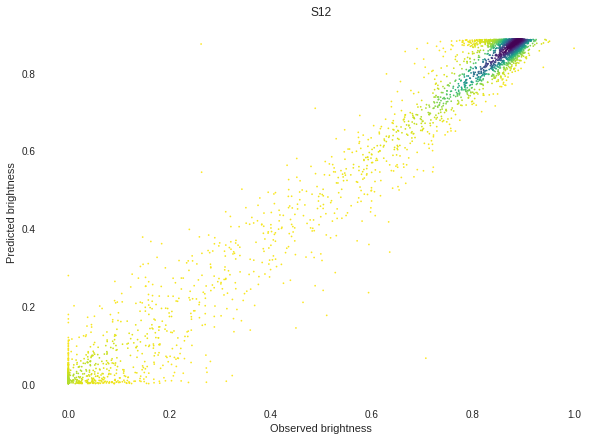

In [25]:
plt.figure(figsize = [10,7])
density_plot(true, predicted, chunk)

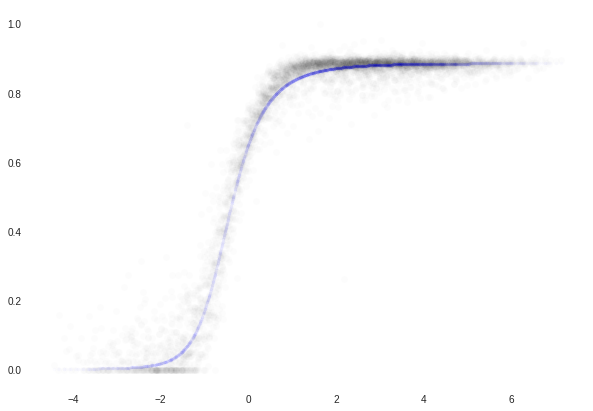

In [26]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential, true, 'ok', alpha = 0.01)
plt.plot(fitness_potential, predicted, '.b', alpha = 0.01);

In [27]:
slope, intercept, r_value, p_value, std_err = stats.linregress(labels,predicted)
r_value

0.98758282849261581

***

# 2. Training all the segments with the chosen architecture

#### 2.1. Training

In [33]:
true = {}
predicted = {}
fitness_potential = {}
hist = {}
weights = {}
biases = {}
aa_seq = {}

In [52]:
for chunk in ['S5']:
    print (chunk)
    data, labels, unique_mutations, aa_seq[chunk] = read_data(chunk)
    
    model = Sequential()
    init = initializers.Orthogonal(gain=1.0, seed=None)

    model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
    model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)
    
    hist[chunk] = model.fit(data, labels, epochs=500, batch_size=500, shuffle=True, verbose=0)
    proba = model.predict_proba(data, batch_size=500, verbose=0)
    
    weights[chunk] = model.layers[0].get_weights()[0]
    biases[chunk] = model.layers[0].get_weights()[1]
    
    true[chunk] = labels
    predicted[chunk] = proba.flatten()
    fitness_potential[chunk] = data.dot(weights[chunk])

S5


#### 2.2. Extracting residuals

In [59]:
residualsDF = {}

for chunk in chunks:
    residualsDF[chunk] = pd.DataFrame(predicted[chunk] - true[chunk], index = aa_seq[chunk])
    residualsDF[chunk].columns = ['predictedMinusObserved']
    residualsDF[chunk].to_csv('../residuals/' + chunk + '.csv', sep=',')

#### 2.3. Plotting

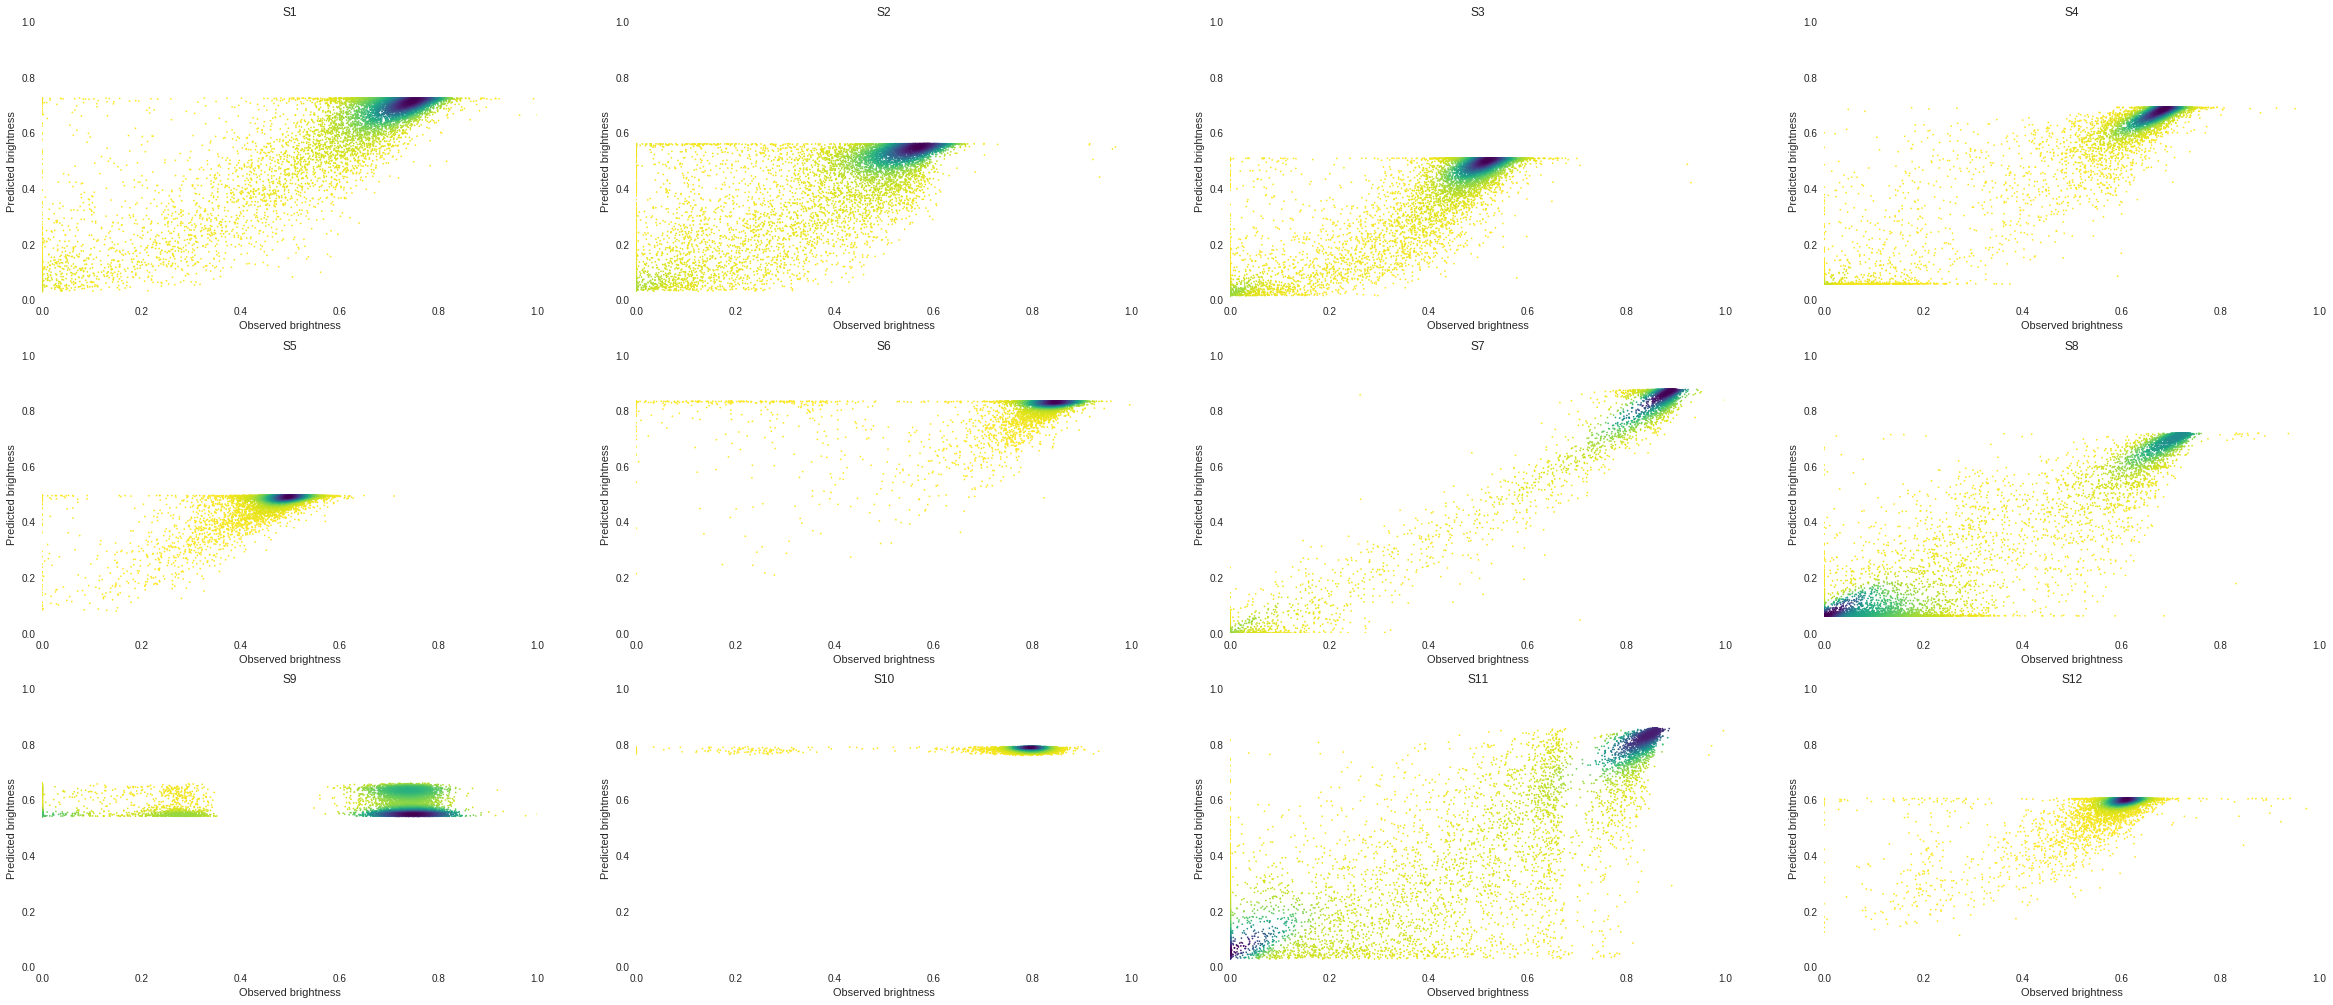

In [53]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.ylim(0,1)
    plt.xlim(0,1)
    density_plot(true[chunk][:10000], predicted[chunk][:10000], chunk)
    count+=1

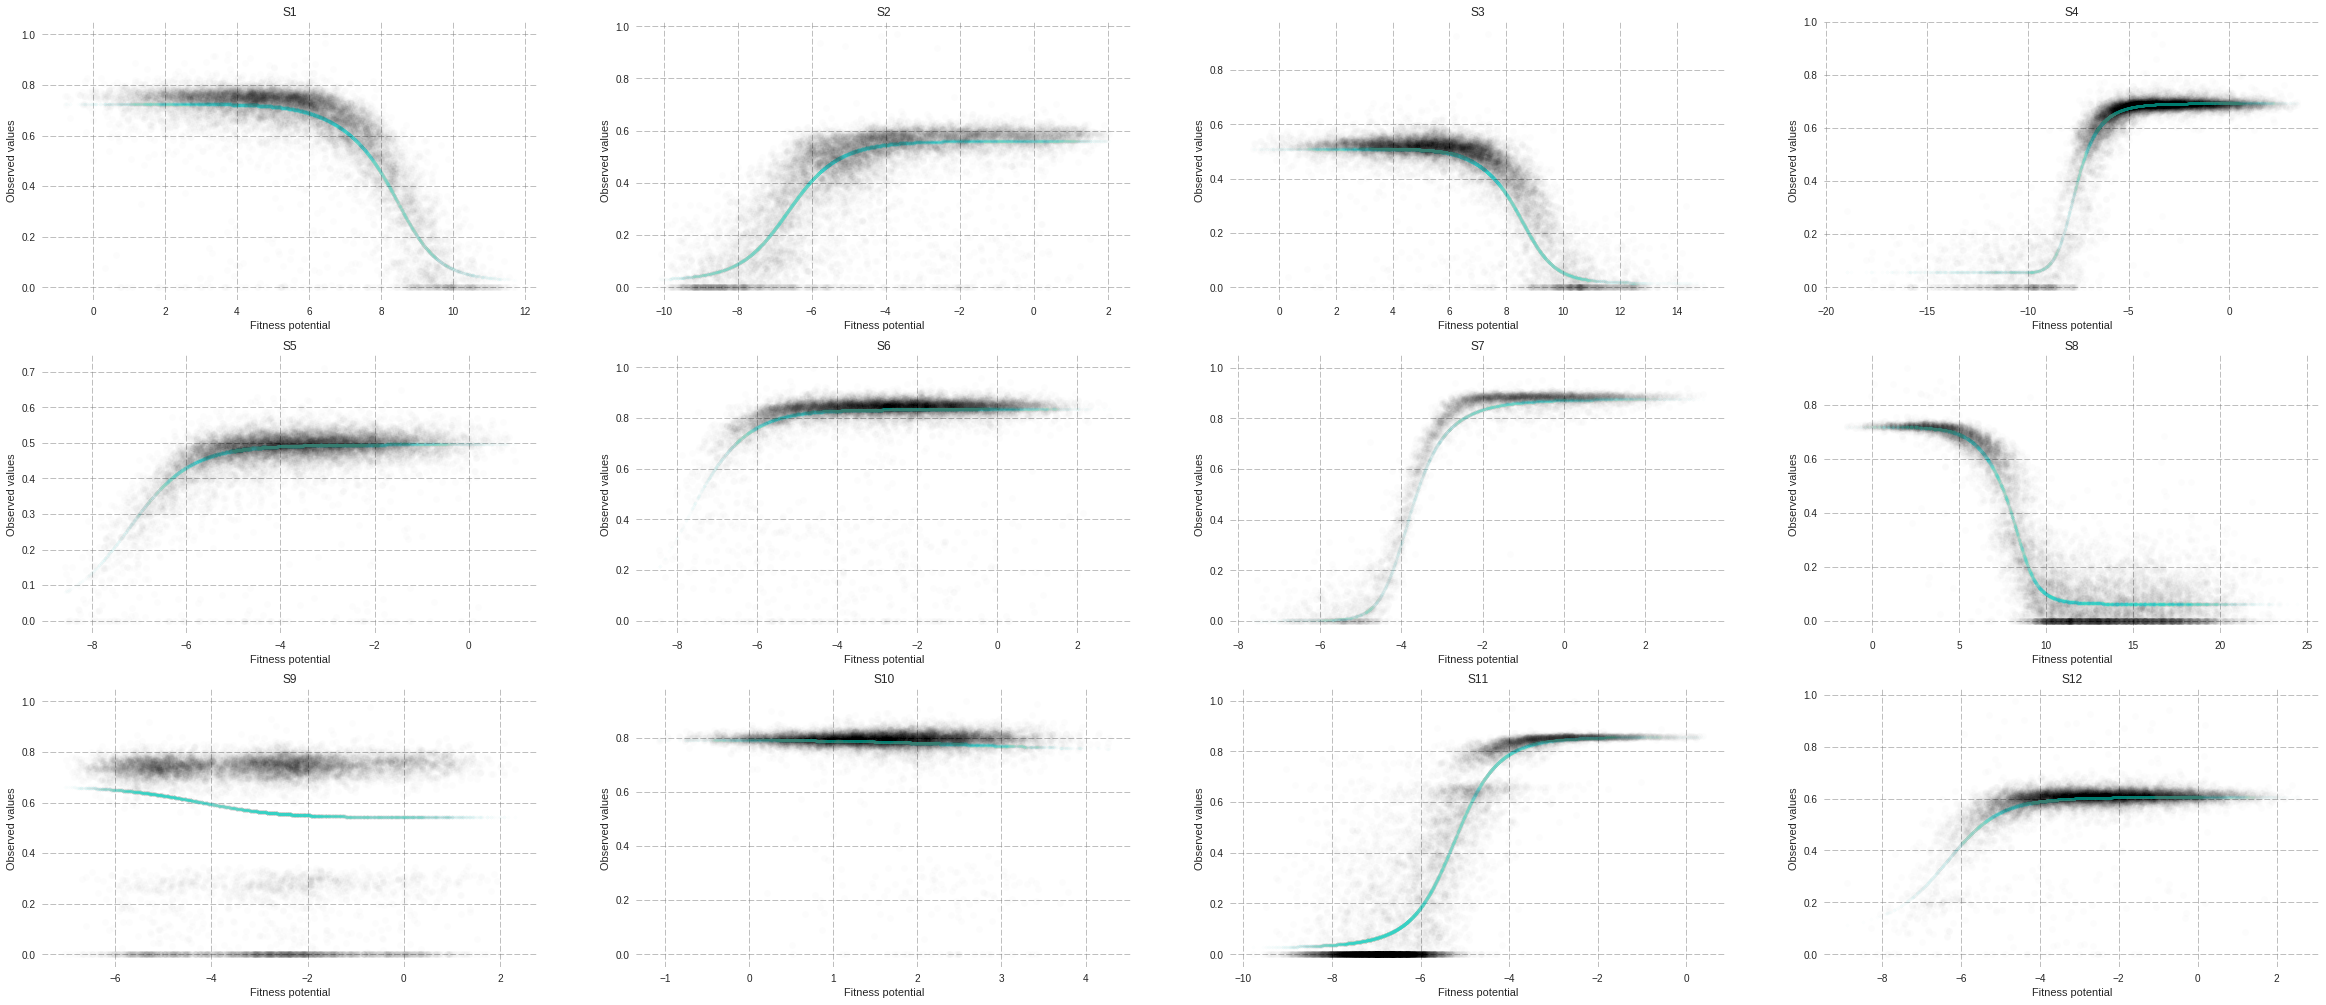

In [54]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    X = fitness_potential[chunk][:10000]
    Y = true[chunk][:10000]
    plt.plot(X, Y, 'ok', alpha = 0.01)
    plt.plot(X, predicted[chunk][:10000], '.', c='#36D1C4', alpha = 0.01)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Fitness potential')
    plt.ylabel('Observed values')
    count+=1

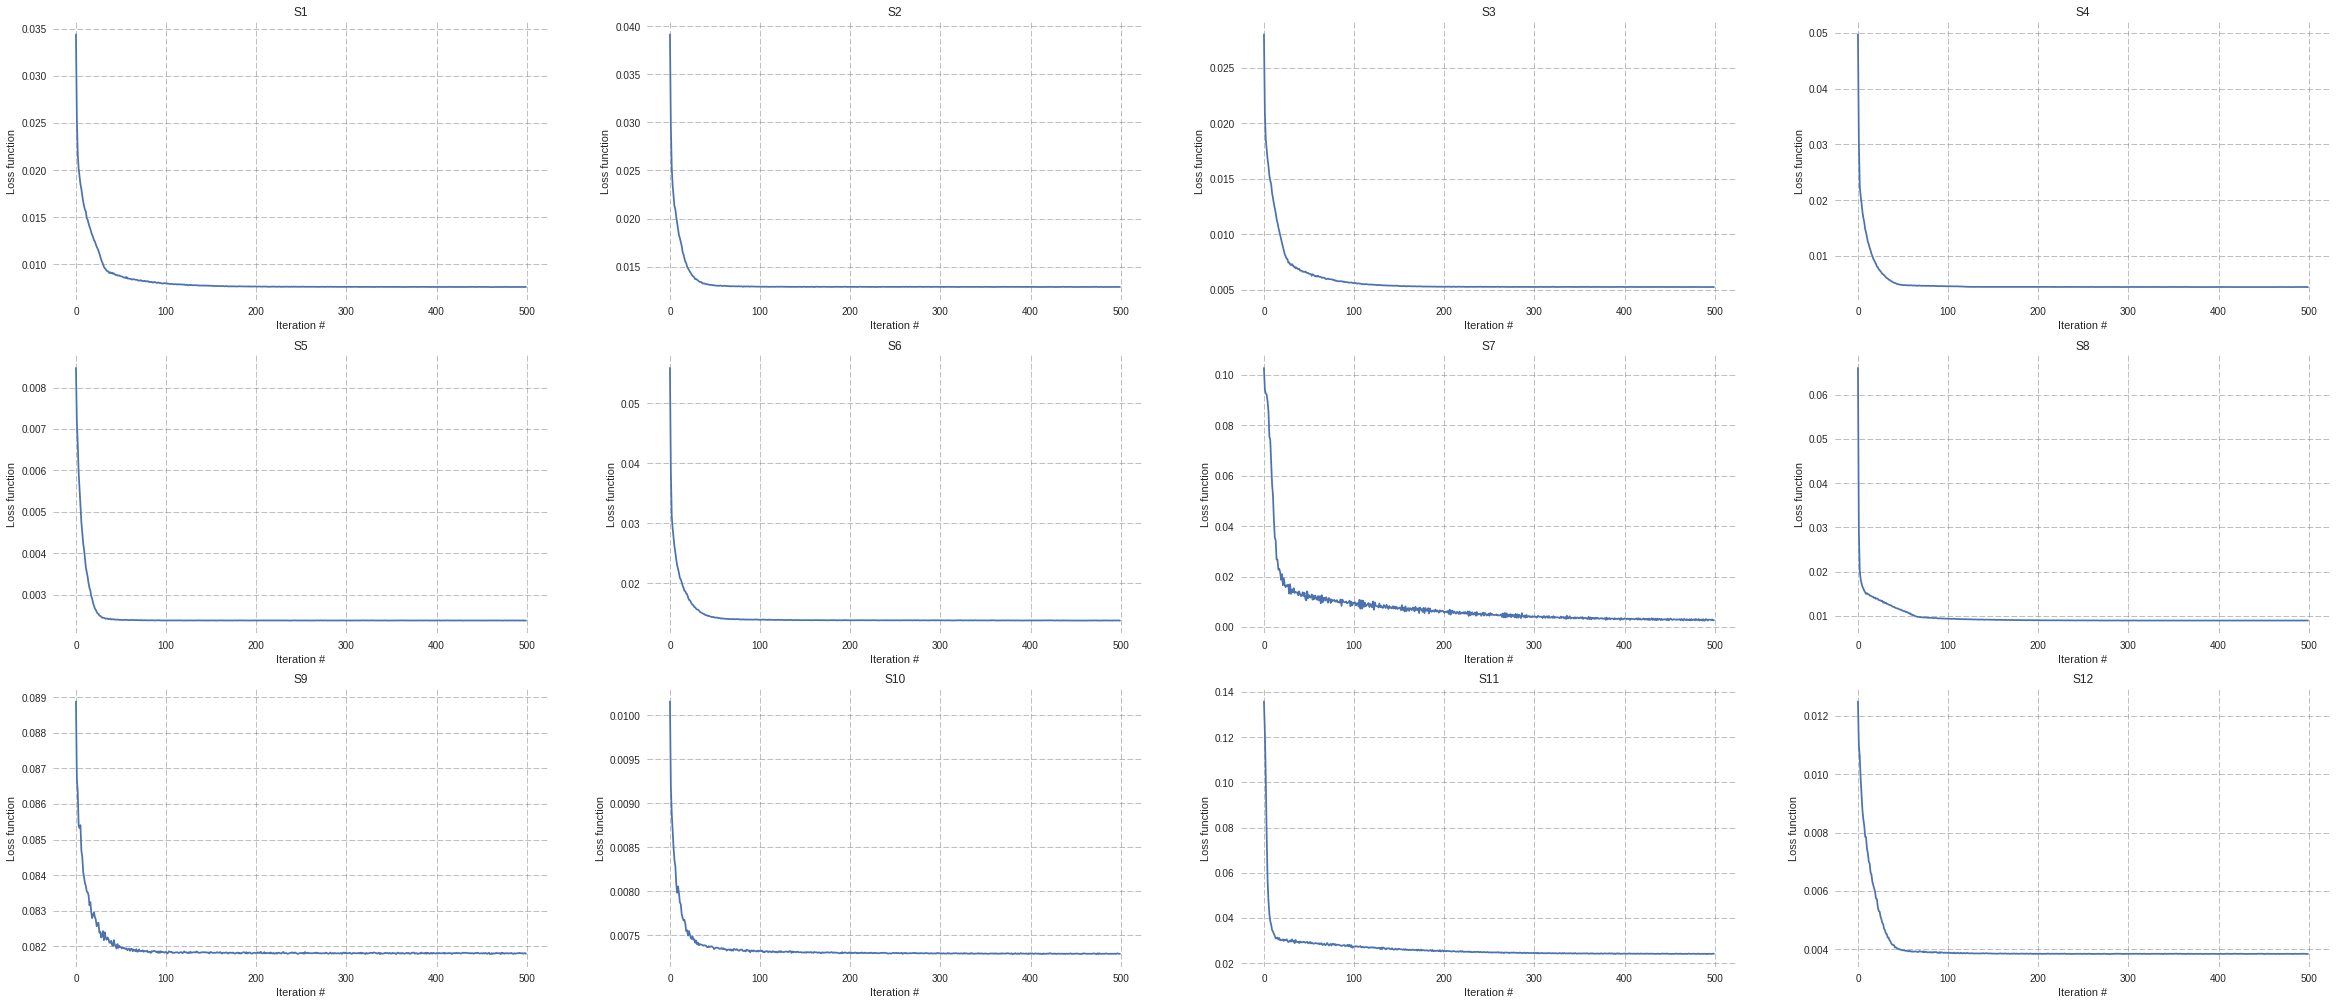

In [55]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.plot([x for x in range(500)], hist[chunk].history['loss'])
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss function')
    count+=1

# 3. Checking correlations and loss function

### 3.1. Correlations prediction vs observed + Lucas's values

In [56]:
mse = []

for chunk in chunks:
    mse.append(hist[chunk].history['loss'][-1])

In [57]:
r_values = []

for chunk in chunks:
    y = true[chunk]
    y_pred = predicted[chunk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,y_pred)
    r_values.append(r_value)
    
lucas = [0.76386, 0.62877, 0.80256, 0.91289, 0.49342, 0.15075, 0.97532, 0.88078, 0.01069, 0.0096183, 0.81741, 0.54172]

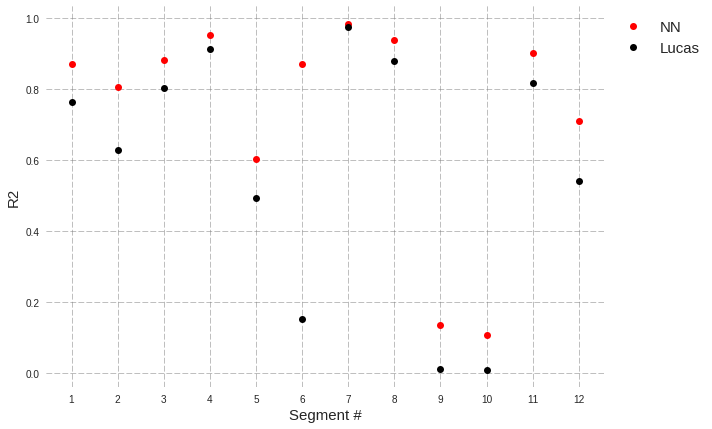

In [58]:
plt.figure(figsize=[10,7])
plt.plot([x for x in range(1, 13)], r_values, 'or', label='NN')
plt.plot([x for x in range(1, 13)], lucas, 'ok', label='Lucas')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Segment #', fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.ylabel('R2', fontsize=15)
plt.xticks([x for x in range(1,13)]);

### 3.2. Mean Squared Error

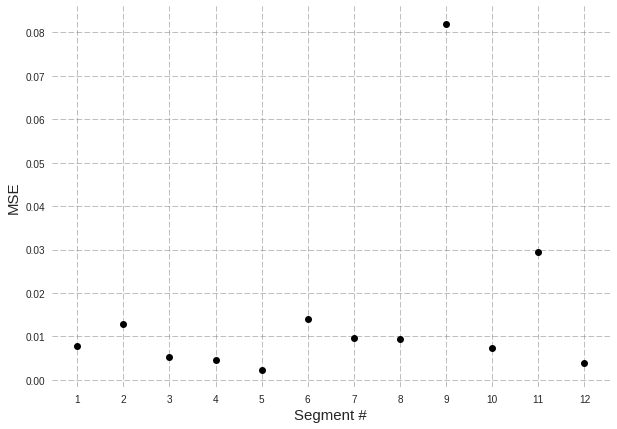

In [169]:
plt.figure(figsize=[10,7])
plt.plot([x for x in range(1, 13)], mse, 'ok')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Segment #', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.xticks([x for x in range(1,13)]);

# 4. Crossvalidation

### 4.1. Comparing train and test sets accuracy predictions

In [ ]:
test_r2 = {}
train_r2 = {}

for chunk in chunks:
    print (chunk)
    data, labels = read_data(chunk)
    
    cv = cross_validation.StratifiedKFold(labels, n_folds = 10, shuffle = True)

    test_r2[chunk] = []
    train_r2[chunk] = []

    for train_idx, test_idx in cv:
        X_train, y_train = data[train_idx,:], labels[train_idx]
        X_test, y_test = data[test_idx,:],labels[test_idx]

        model = Sequential()
        init = initializers.Orthogonal(gain=1.0, seed=None)

        model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
        model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
        model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

        opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

        model.compile(optimizer=opt,
                      loss='mean_squared_error',
                      verbose=0)

        model.fit(X_train, y_train, epochs=100, batch_size=500, shuffle=True, verbose=0)
        proba_train = model.predict_proba(X_train, batch_size=500, verbose=0)
        proba_test = model.predict_proba(X_test, batch_size=500, verbose=0)

        predicted_train = proba_train.flatten()
        predicted_test = proba_test.flatten()

        _, _, Rtrain, _, _ = stats.linregress(y_train, predicted_train)
        _, _, Rtest, _, _ = stats.linregress(y_test, predicted_test)

        test_r2[chunk].append(Rtest)
        train_r2[chunk].append(Rtrain)

S1


In [180]:
train_r2['S5']

[0.60423015365282018,
 0.0,
 -0.00039742165628629421,
 0.6018810801083414,
 0.60497792503494985,
 -0.0018418963715206196,
 0.60649436280492008,
 0.60024094578788734,
 -0.00057688693933001848,
 0.60018624848174496]

KeyError: 'S1'

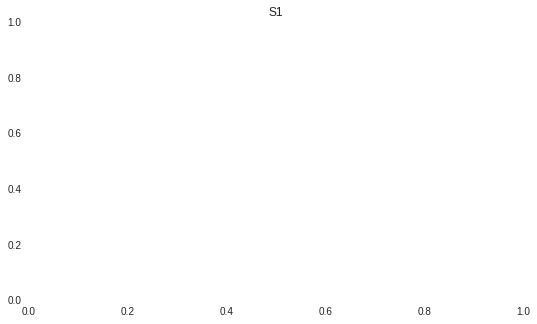

In [179]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.boxplot([train_r2[chunk], test_r2[chunk]], labels=['Train set', 'Test set'])
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.ylabel('R2')
    plt.ylim(0,1)
    count+=1

### 4.2. Checking accuracy dependence from the test set size

In [171]:
from sklearn.model_selection import train_test_split
nfold=10
data, labels = read_data(chunk)

for size in [0.1, 0.05, 0.01, 0.001, 0]:
    print (size)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=size)

    cv = cross_validation.KFold(labels.shape[0], n_folds = nfold, shuffle = True)

    model = Sequential()
    init = initializers.Orthogonal(gain=1.0, seed=None)

    model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer=init))
    model.add(Dense(100, activation='sigmoid', kernel_initializer=init))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)

    model.fit(X_train, y_train, epochs=500, batch_size=500, shuffle=True, verbose=0)
    proba_train = model.predict_proba(X_train, batch_size=500, verbose=0)

    predicted_train = proba_train.flatten()
    _, _, Rtrain, _, _ = stats.linregress(y_train, predicted_train)

    if size != 0:
        proba_test = model.predict_proba(X_test, batch_size=500, verbose=0)
        predicted_test = proba_test.flatten()
        _, _, Rtest, _, _ = stats.linregress(y_test, predicted_test)
        print (Rtest)
        
    print (Rtrain)

0.05


KeyboardInterrupt: 

In [ ]:
x = [0.1, 0.05, 0.01, 0.001, 0]
test = Rtest
train = Rtrain

plt.figure(figsize=[10,3])
plt.plot(x, train, 'ok', alpha = 0.7, markersize=5, label='train')
plt.plot(x[:-1], test, 'om', alpha = 0.7, markersize=5, label='test')
plt.grid(True, ls='--', lw=0.5, dash_capstyle='round', c='gray')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.ylim(0,1)
plt.xlim(-0.005,0.105)
plt.xticks([i for i in np.arange(0,0.11,0.01)])
plt.xlabel('Test set fraction', fontsize=10)
plt.ylabel('R2', fontsize=10)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='left')
x = [-1, 1]
plt.plot(x, [0.9 for i in x], ':k', lw=0.7);